# Airport Weather Clustering & Severity-Trend Analysis

We cluster U.S. **airport weather stations** using counts of event **Type**s and
**Severity** classes, then explore how each cluster’s average
severity changes over time.



In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
DATA_PATH = "weather.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["StartTime(UTC)", "EndTime(UTC)"])
print(f"Events: {len(df):,}  |  Airports: {df['AirportCode'].nunique()}")



Events: 8,627,181  |  Airports: 2071


In [3]:
print(df.isna().sum())
print("\nHighest null ratio value of dataset column: 'ZipCode'")
df.ZipCode.isna().sum() / len(df)

EventId                  0
Type                     0
Severity                 0
StartTime(UTC)           0
EndTime(UTC)             0
Precipitation(in)        0
TimeZone                 0
AirportCode              0
LocationLat              0
LocationLng              0
City                 16912
County                   0
State                    0
ZipCode              69199
dtype: int64

Highest null ratio value of dataset column: 'ZipCode'


np.float64(0.00802104418581226)

In [4]:
df = df.dropna()

## Add event *Duration* in hours

* drop negative / zero durations  
* drop events longer than 30 days (>= 720 h)


In [5]:
df["Duration"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600

df = df[(df["Duration"] > 0) & (df["Duration"] < 30*24)]
print("After filtering:", len(df))


After filtering: 8557599


In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import plotly.express as px


In [7]:
# Step 1: Compute event durations
df["dur_h"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600
df = df[(df["dur_h"] > 0) & (df["dur_h"] < 30*24)]

# Step 2: Count events per airport × type
event_counts = df.groupby(["AirportCode", "Type"])["EventId"].count().unstack().fillna(0)

# Step 4: Reset for modeling
df_flat = event_counts.reset_index()


In [8]:
def print_duration_stats(df):
    print("Duration Summary by Hours")
    print("Count  ",df['Duration'].size)
    print("% Null ",df['Duration'].isnull().mean())
    print("Size   ",df['Duration'].unique().size)
    print("Min    ",df['Duration'].min())
    print("1stQrt ",df['Duration'].quantile(0.25))
    print("Mean   ",df['Duration'].mean())
    print("Median ",df['Duration'].median())
    print("3rdQrt ",df['Duration'].quantile(0.75))
    print("95%    ",df['Duration'].mean()+1.96*df['Duration'].std())
    print("Max    ",df['Duration'].max())
    print("Std    ",df['Duration'].std())
    
print_duration_stats(df)

Duration Summary by Hours
Count   8557599
% Null  0.0
Size    4227
Min     0.016666666666666666
1stQrt  0.3333333333333333
Mean    1.311761745321321
Median  0.6666666666666666
3rdQrt  1.2666666666666666
95%     9.970511488738017
Max     718.6666666666666
Std     4.417729460926886


## There appears to be really outlier values which will get in our way of analyzing the general behaviour of our data

In [9]:
df = df[df.Duration < 10]
print_duration_stats(df)

Duration Summary by Hours
Count   8464084
% Null  0.0
Size    599
Min     0.016666666666666666
1stQrt  0.3333333333333333
Mean    1.1041209775328316
Median  0.6666666666666666
3rdQrt  1.1833333333333333
95%     3.759738150504285
Max     9.983333333333333
Std     1.3549067209038028


In [10]:
df2 = df.groupby(['AirportCode','City','State', 
                  'LocationLat', 'LocationLng','Type', 'Severity']).agg({'Duration':['sum']}).reset_index()
df2.columns = pd.MultiIndex.from_tuples((("AirportCode", " "),("City", " "),
                                         ("State", " "), ("LocationLat", " "),
                                         ("LocationLng", " "), ("Type", " "), ("Severity", " "),
                                         ("Duration", " ")))
df2.columns = df2.columns.get_level_values(0)
df2['Duration'] = df2['Duration'] / (24*6*3.65) # Yearly Percentage
df2 = df2.sort_values(by='Duration')
df2.tail(3)

,AirportCode,City,State,LocationLat,LocationLng,Type,Severity,Duration
3104,KBOK,Brookings,OR,42.0744,-124.2900,Rain,Light,14.656171
1916,KAST,Warrenton,OR,46.1569,-123.8825,Rain,Light,15.310946
19591,KUIL,Forks,WA,47.9375,-124.5550,Rain,Light,16.311707


In [11]:
south = ['AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'MS', 'LA', 'AR', 'OK', 'TX']
atlantic = ['KY', 'VA', 'WV', 'MD', 'DE', 'PA', 'NJ']
new_england = ['NY', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
midwest = ['OH', 'IN', 'MI', 'IL', 'WI', 'IA', 'MO', 'MN', 'NE', 'KS', 'SD', 'ND']
west = ['MT', 'WY', 'ID', 'NV', 'UT', 'CO', 'AZ', 'NM']
pacific = ['AK', 'WA', 'OR', 'CA', 'HI']
df2.loc[df2['State'].isin(south), 'Region'] = 'South'
df2.loc[df2['State'].isin(atlantic), 'Region'] = 'Atlantic'
df2.loc[df2['State'].isin(new_england), 'Region'] = 'New England'
df2.loc[df2['State'].isin(midwest), 'Region'] = 'Midwest'
df2.loc[df2['State'].isin(west), 'Region'] = 'West'
df2.loc[df2['State'].isin(pacific), 'Region'] = 'Pacific'
df2 = df2[['AirportCode', 'City', 'State', 'Region', 'LocationLat', 'LocationLng', 'Type', 'Severity', 'Duration']]
df2.tail(3)

,AirportCode,City,State,Region,LocationLat,LocationLng,Type,Severity,Duration
3104,KBOK,Brookings,OR,Pacific,42.0744,-124.2900,Rain,Light,14.656171
1916,KAST,Warrenton,OR,Pacific,46.1569,-123.8825,Rain,Light,15.310946
19591,KUIL,Forks,WA,Pacific,47.9375,-124.5550,Rain,Light,16.311707


In [12]:
pre_flat = df.groupby(['AirportCode','City','State', 
                  'LocationLat', 'LocationLng','Type']).agg({'Duration':['sum']}).reset_index()
pre_flat.columns = pd.MultiIndex.from_tuples((("AirportCode", " "),("City", " "),
                                              ("State", " "), ("LocationLat", " "),
                                              ("LocationLng", " "), ("Type", " "),
                                              ("Duration", " ")))
pre_flat.columns = pre_flat.columns.get_level_values(0)
pre_flat['Duration'] = pre_flat['Duration'] / (24*6*3.65) # Yearly Percentage
pre_flat = pre_flat.sort_values(by='Duration')
pre_flat.tail(3)

,AirportCode,City,State,LocationLat,LocationLng,Type,Duration
1100,KAST,Warrenton,OR,46.1569,-123.8825,Rain,17.155410
280,K3TH,Thompson Falls-West End,MT,47.6000,-115.3667,Snow,17.188705
11247,KUIL,Forks,WA,47.9375,-124.5550,Rain,19.156044


In [13]:
df_flat = pre_flat.pivot_table(index='AirportCode', columns='Type', values=['Duration']).reset_index().fillna(0)
df_flat.columns = pd.MultiIndex.from_tuples(((' ', 'AirportCode'),(' ', 'Cold'),(' ', 'Fog'),
            (' ',  'Hail'),(' ', 'Precipitation'),(' ', 'Rain'),(' ', 'Snow'),(' ', 'Storm')))
df_flat.columns = df_flat.columns.get_level_values(1)
uniqueKey = df2[['AirportCode', 'City', 
                 'State', 'Region', 'LocationLat', 'LocationLng']].sort_values(by='AirportCode').drop_duplicates()
weather = pd.merge(df_flat, uniqueKey, how='inner', on='AirportCode')
weather.tail(3)

,AirportCode,Cold,Fog,Hail,Precipitation,Rain,Snow,Storm,City,State,Region,LocationLat,LocationLng
2051,KYNG,0.013128,2.850076,0.011035,0.108733,10.416794,5.350996,0.003647,Vienna,OH,Midwest,41.2544,-80.6739
2052,KZPH,0.536530,1.993278,0.000000,0.058980,5.019660,0.000000,0.001903,Zephyrhills,FL,South,28.2281,-82.1559
2053,KZZV,0.021848,2.149480,0.000000,0.105308,6.834792,1.987475,0.000000,Zanesville,OH,Midwest,39.9444,-81.8921


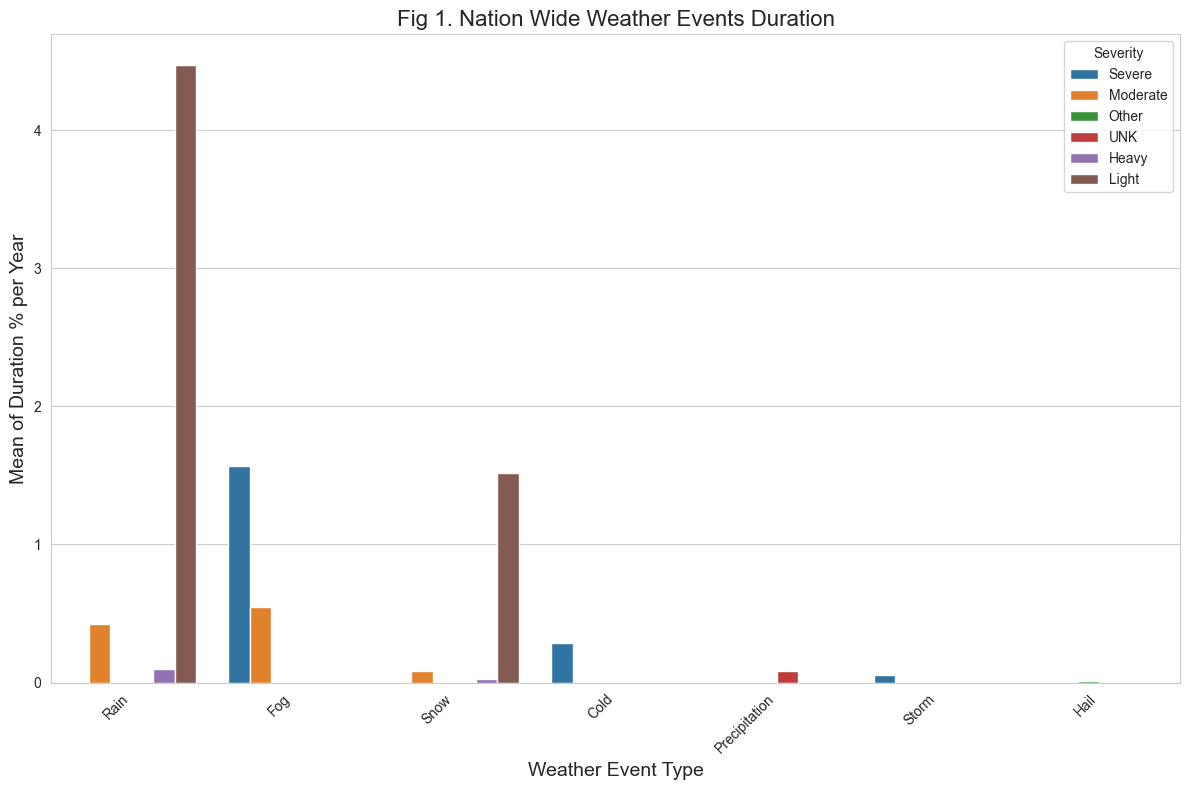

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group data by Type and Severity, computing mean duration
df_grouped = df2.groupby(['Type', 'Severity'], as_index=False)['Duration'].mean()

# Sort the Types by overall mean Duration (across all Severity levels)
type_order = (
    df_grouped.groupby('Type')['Duration']
    .mean()
    .sort_values(ascending=False)
    .index
)

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot barplot with seaborn for cleaner visual aesthetics
sns.barplot(
    data=df_grouped,
    x='Type',
    y='Duration',
    hue='Severity',
    order=type_order
)

# Set plot titles and labels
plt.title('Fig 1. Nation Wide Weather Events Duration', fontsize=16)
plt.xlabel('Weather Event Type', fontsize=14)
plt.ylabel('Mean of Duration % per Year', fontsize=14)

# Rotate x labels if too crowded
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Severity')

# Show plot
plt.tight_layout()
plt.show()


In [15]:
from sklearn.cluster import KMeans

# --- 1) Drop identifier and unwanted columns ---
X = df_flat.drop(['AirportCode', 'Cold', 'Hail'], axis=1)

# --- 2) Convert all columns to numeric (fixes your error) ---
X = X.apply(pd.to_numeric, errors='coerce')  # forces conversion; puts NaN on failure
X = X.fillna(0)  # replace any NaNs with 0 just in case

# --- 3) Compute inverse frequency weights ---
presence = (X > 0).sum(axis=0)  # number of airports with event type
fraction_present = presence / len(X)
inv_freq_weights = 1 / fraction_present
inv_freq_weights = inv_freq_weights / inv_freq_weights.min()  # normalize

# --- 4) Apply weights ---
X_weighted = X * inv_freq_weights

# Optional: Inspect
print("Weights:\n", inv_freq_weights.sort_values())
X_weighted.tail(3)


Weights:
 Fog              1.000000
Rain             1.010649
Precipitation    1.048947
Snow             1.098072
Storm            1.176505
dtype: float64


,Fog,Precipitation,Rain,Snow,Storm
2051,2.850076,0.114055,10.527723,5.875777,0.004290
2052,1.993278,0.061867,5.073115,0.000000,0.002238
2053,2.149480,0.110463,6.907576,2.182389,0.000000


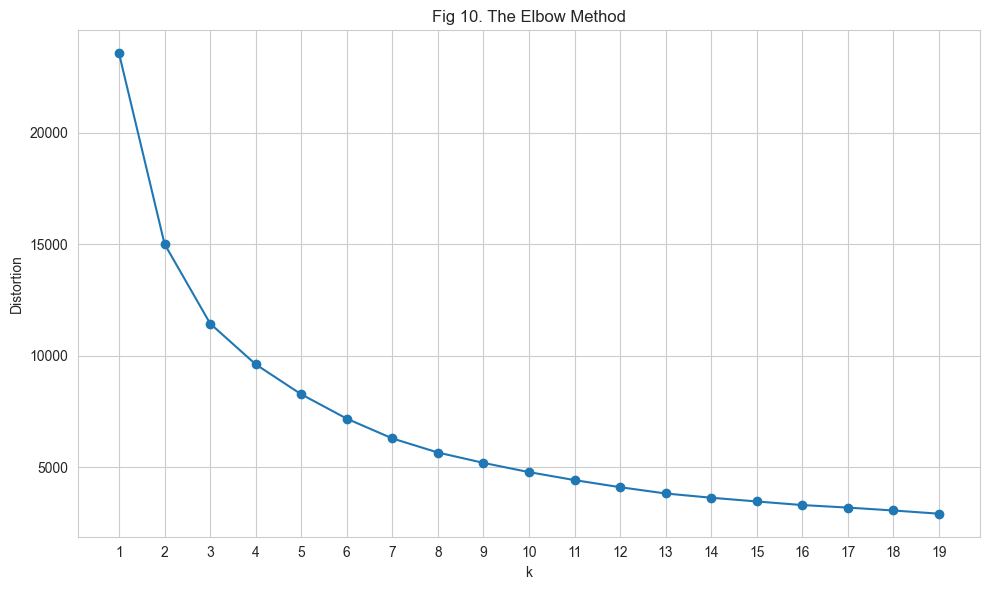

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate distortions (inertia) for k = 1 to 19
distortions = []
K = range(1, 20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init=50, max_iter=500)
    kmean.fit(X)
    distortions.append(kmean.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, marker='o')
plt.title('Fig 10. The Elbow Method')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(K)
plt.grid(True)
plt.tight_layout()
plt.show()


## Clustering Airports by Weather Patterns

Using K-Means (k=4), we group airports into clusters based on their weather profiles. Each cluster represents a set of airports with similar distributions of event types, durations, and severities.

The cluster labels are then merged back into the airport-level feature matrix for visualization and analysis.


In [17]:
from sklearn.cluster import KMeans

# Step 1: Prepare the feature matrix (drop Cold and Hail)
X = df_flat.drop(['AirportCode', 'Cold', 'Hail'], axis=1)

# Step 2: KMeans clustering (using k-means++ init)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans.fit(X)

# Step 3: Assign cluster labels
df_flat['Cluster'] = kmeans.labels_.astype(str)

# Step 4: Merge with weather data (excluding Cold and Hail)
df_cluster = pd.merge(
    df_flat[['AirportCode', 'Cluster']],
    weather.drop(['Cold', 'Hail'], axis=1),
    how='inner',
    on='AirportCode'
)

# Step 5: Preview result
df_cluster.tail(3)


,AirportCode,Cluster,Fog,Precipitation,Rain,Snow,Storm,City,State,Region,LocationLat,LocationLng
2051,KYNG,2,2.850076,0.108733,10.416794,5.350996,0.003647,Vienna,OH,Midwest,41.2544,-80.6739
2052,KZPH,3,1.993278,0.058980,5.019660,0.000000,0.001903,Zephyrhills,FL,South,28.2281,-82.1559
2053,KZZV,2,2.149480,0.105308,6.834792,1.987475,0.000000,Zanesville,OH,Midwest,39.9444,-81.8921


In [22]:
import plotly.express as px
import plotly.io as pio

# Ensure Plotly shows in notebooks (if you're using one)
pio.renderers.default = "browser"  # or "browser", "iframe", etc. depending on your setup

# Convert Cluster to string (if not already)
df_cluster["Cluster_str"] = df_cluster["Cluster"].astype(str)

# Optional: Add hover text (e.g., airport info)
df_cluster["hover_text"] = (
    "Airport: " + df_cluster["AirportCode"] +
    "<br>Cluster: " + df_cluster["Cluster_str"]
)

# Create the interactive scatter geo plot
fig = px.scatter_geo(
    df_cluster,
    lat="LocationLat",
    lon="LocationLng",
    color="Cluster_str",
    hover_name="hover_text",
    scope="usa",
    title="Airport Cluster Distribution (k=4, KMeans++)",
    category_orders={"Cluster_str": sorted(df_cluster["Cluster_str"].unique())}
)

# Optional aesthetic tweaks
fig.update_traces(marker=dict(size=6))
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
# Save the plot as an interactive HTML file
fig.write_html("airport_cluster_map.html")
# Show the interactive figure
fig.show()

In [27]:
import pandas as pd

# Load the airport metadata
airports_df = pd.read_csv("airports.csv")

# Merge df_cluster with airport data using ICAO code
merged = df_cluster.merge(airports_df, left_on="AirportCode", right_on="icao", how="left")

# Extract IATA code ("code") and cluster, remove entries without valid IATA codes
iata_clusters = (
    merged[["code", "Cluster"]]
    .dropna(subset=["code"])
    .drop_duplicates()
    .rename(columns={"code": "AirportCode"})  # rename to standard name
)

# Save to CSV
output_path = "airport_cluster_assignments_iata.csv"
iata_clusters.to_csv(output_path, index=False)

print(f"IATA-formatted cluster CSV saved to: {output_path}")


IATA-formatted cluster CSV saved to: airport_cluster_assignments_iata.csv


## Weather Type Distribution per Cluster

We analyze how much each cluster is affected by different types of weather events. For each cluster, we calculate the **proportion of total duration** spent under each weather type.

This gives us a high-level view of the dominant weather conditions within each cluster.


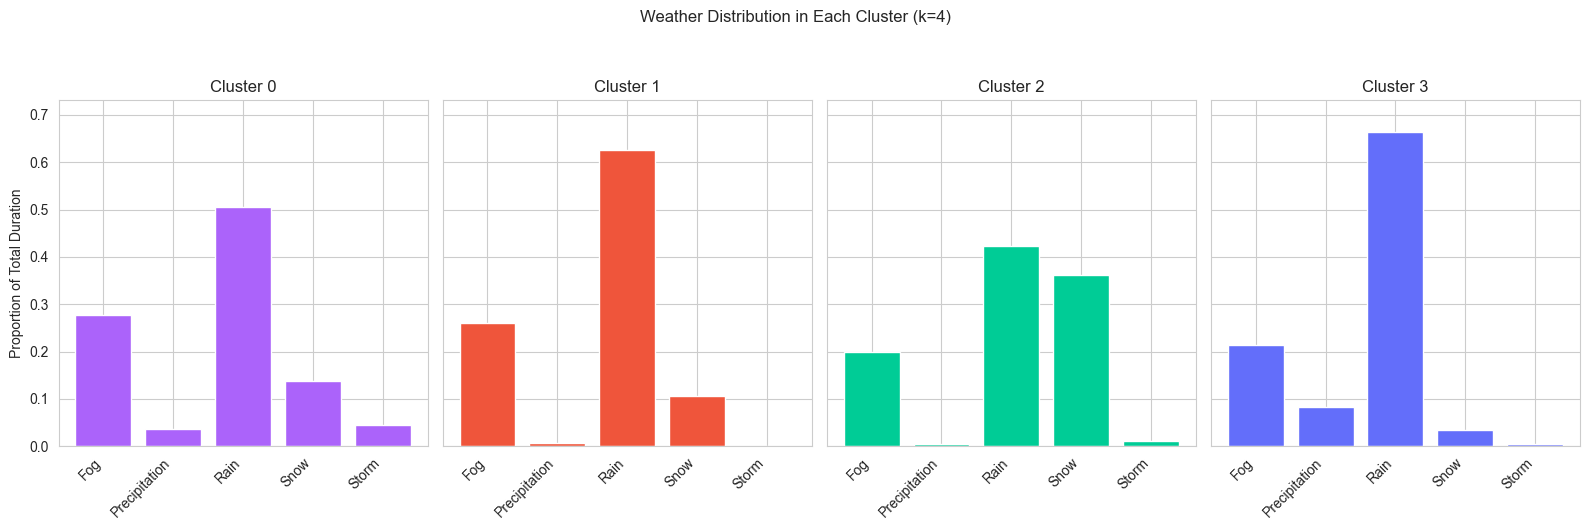

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1) Recompute 'dur_h' and clean the DataFrame ---
df_clean = df.copy()
df_clean["dur_h"] = (df_clean["EndTime(UTC)"] - df_clean["StartTime(UTC)"]).dt.total_seconds() / 3600
df_clean = df_clean[(df_clean["dur_h"] > 0) & (df_clean["dur_h"] < 30*24)]

# --- 2) Compute feature matrix for clustering ---
event_counts = df_clean.groupby(["AirportCode", "Type"])["dur_h"].sum().unstack().fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(event_counts)

# --- 3) Apply KMeans clustering with k=4 ---
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- 4) Build df_cluster with cluster assignments ---
df_cluster = event_counts.reset_index()
df_cluster["Cluster"] = clusters

# --- 5) Define types of interest ---
types = ["Fog", "Precipitation", "Rain", "Snow", "Storm"]
for t in types:
    if t not in event_counts.columns:
        event_counts[t] = 0

# --- 6) Normalize durations to proportions ---
type_prop = event_counts[types].div(event_counts[types].sum(axis=1), axis=0).reset_index()

# --- 7) Merge with cluster assignments ---
plot_df = type_prop.merge(df_cluster[["AirportCode", "Cluster"]], on="AirportCode")

# --- 8) Compute cluster-wise mean weather type proportions ---
cluster_means = plot_df.groupby("Cluster")[types].mean()

# --- 9) Plot with consistent US map colors ---
clusters = sorted(cluster_means.index)
# Exact same color order as the US map: cluster 0 → purple, 1 → red, 2 → green, 3 → blue
colors = ['#AB63FA', '#EF553B', '#00CC96', '#636EFA']

fig, axes = plt.subplots(1, len(clusters), sharey=True, figsize=(4 * len(clusters), 5))
for ax, (cluster, color) in zip(axes, zip(clusters, colors)):
    vals = cluster_means.loc[cluster, types]
    ax.bar(types, vals, color=color)
    ax.set_title(f"Cluster {cluster}")
    ax.set_xticks(range(len(types)))
    ax.set_xticklabels(types, rotation=45, ha='right')
    if ax is axes[0]:
        ax.set_ylabel("Proportion of Total Duration")
    ax.set_ylim(0, cluster_means.values.max() * 1.1)

fig.suptitle("Weather Distribution in Each Cluster (k=4)", y=1.05)
plt.tight_layout()
plt.show()


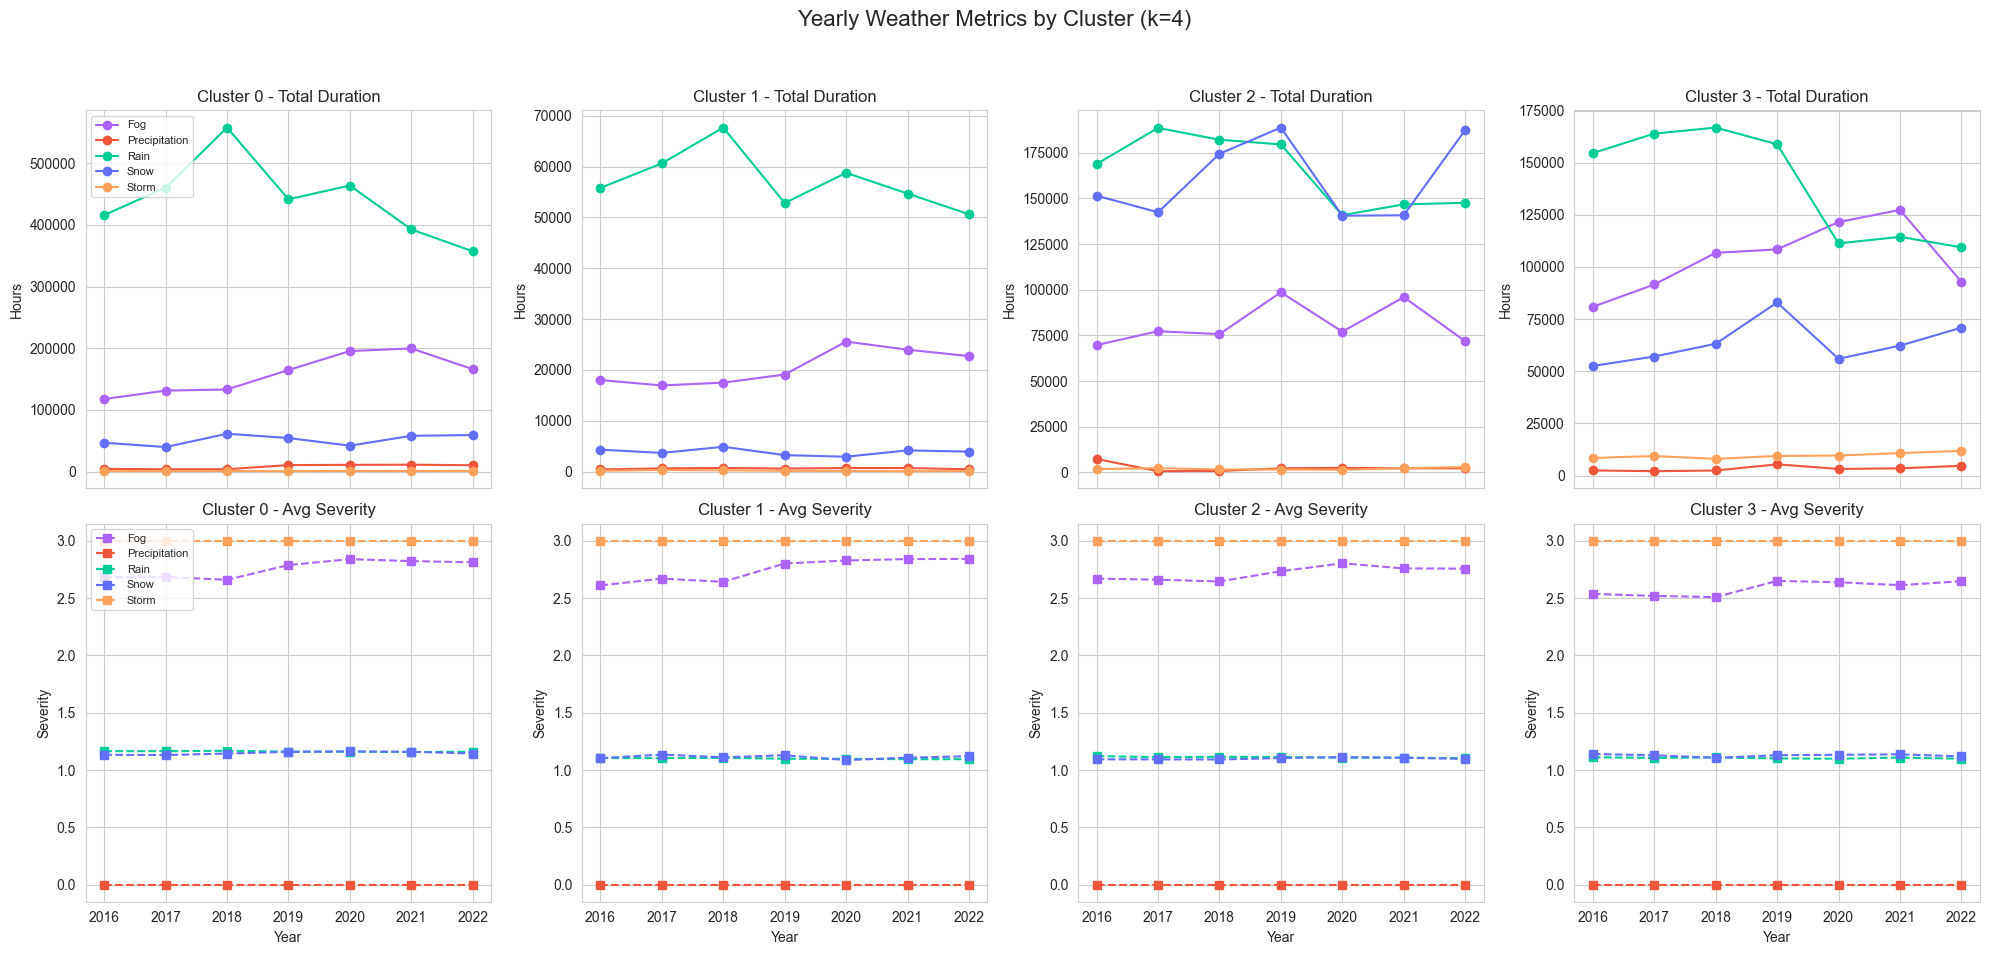

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1) Load & preprocess
df = pd.read_csv(
    "weather.csv",
    parse_dates=["StartTime(UTC)", "EndTime(UTC)"],
    low_memory=False
)
df["dur_h"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600
df = df[(df["dur_h"] > 0) & (df["dur_h"] < 30 * 24)]

sev_map = {"Light": 1, "Moderate": 2, "Severe": 3, "Extreme": 4}
df["sev_num"] = df["Severity"].map(sev_map)

# 2) Build feature matrix & cluster (k=4)
types = ["Fog", "Precipitation", "Rain", "Snow", "Storm"]
agg = (
    df[df["Type"].isin(types)]
      .groupby(["AirportCode", "Type"])
      .agg(count=("EventId", "size"),
           avg_sev=("sev_num", "mean"),
           avg_dur=("dur_h", "mean"))
      .reset_index()
)

count_mat = agg.pivot(index="AirportCode", columns="Type", values="count").fillna(0)
sev_mat   = agg.pivot(index="AirportCode", columns="Type", values="avg_sev").fillna(0)
dur_mat   = agg.pivot(index="AirportCode", columns="Type", values="avg_dur").fillna(0)

features = pd.concat([
    count_mat.add_suffix("_count"),
    sev_mat.add_suffix("_avg_sev"),
    dur_mat.add_suffix("_avg_dur")
], axis=1)

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
labels = kmeans.fit_predict(features.values)
cluster_df = pd.DataFrame({"AirportCode": features.index, "Cluster": labels})

# 3) Merge cluster and extract year
dfc = df.merge(cluster_df, on="AirportCode")
dfc["year"] = dfc["StartTime(UTC)"].dt.year

# 4) Plot total duration & avg severity by cluster
clusters = sorted(dfc["Cluster"].unique())
years = sorted(dfc["year"].unique())

# Same color palette as US map
type_colors = {
    "Fog": "#AB63FA",
    "Precipitation": "#EF553B",
    "Rain": "#00CC96",
    "Snow": "#636EFA",
    "Storm": "#FFA15A"
}

fig, axes = plt.subplots(2, len(clusters), figsize=(5 * len(clusters), 10), sharex='col')

for j, c in enumerate(clusters):
    sub = dfc[dfc["Cluster"] == c]

    # Total duration
    td = sub.groupby(["year", "Type"])["dur_h"].sum().unstack(fill_value=0)
    ax = axes[0, j]
    for t in types:
        ax.plot(years, td.reindex(years).get(t, [0]*len(years)),
                marker='o', color=type_colors[t], label=t)
    ax.set_title(f"Cluster {c} - Total Duration")
    ax.set_ylabel("Hours")
    ax.set_xticks(years)
    if j == 0:
        ax.legend(loc='upper left', fontsize=8)

    # Average severity
    ax2 = axes[1, j]
    for t in types:
        sev = sub[sub["Type"] == t].groupby("year")["sev_num"].mean()
        ax2.plot(years, sev.reindex(years).fillna(0),
                 marker='s', linestyle='--', color=type_colors[t], label=t)
    ax2.set_title(f"Cluster {c} - Avg Severity")
    ax2.set_ylabel("Severity")
    ax2.set_xticks(years)
    if j == 0:
        ax2.legend(loc='upper left', fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel("Year")

plt.suptitle("Yearly Weather Metrics by Cluster (k=4)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Trend Analysis Over Time

To understand how weather patterns evolve, we examine **yearly trends** in both:

- Total event duration,
- Average event severity.

We apply linear regression per `(Cluster, Type)` to identify statistically significant upward or downward trends.


/var/folders/f0/xgjry89x12z1v0vmkmkwz54r0000gn/T/ipykernel_3836/987884182.py:74: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



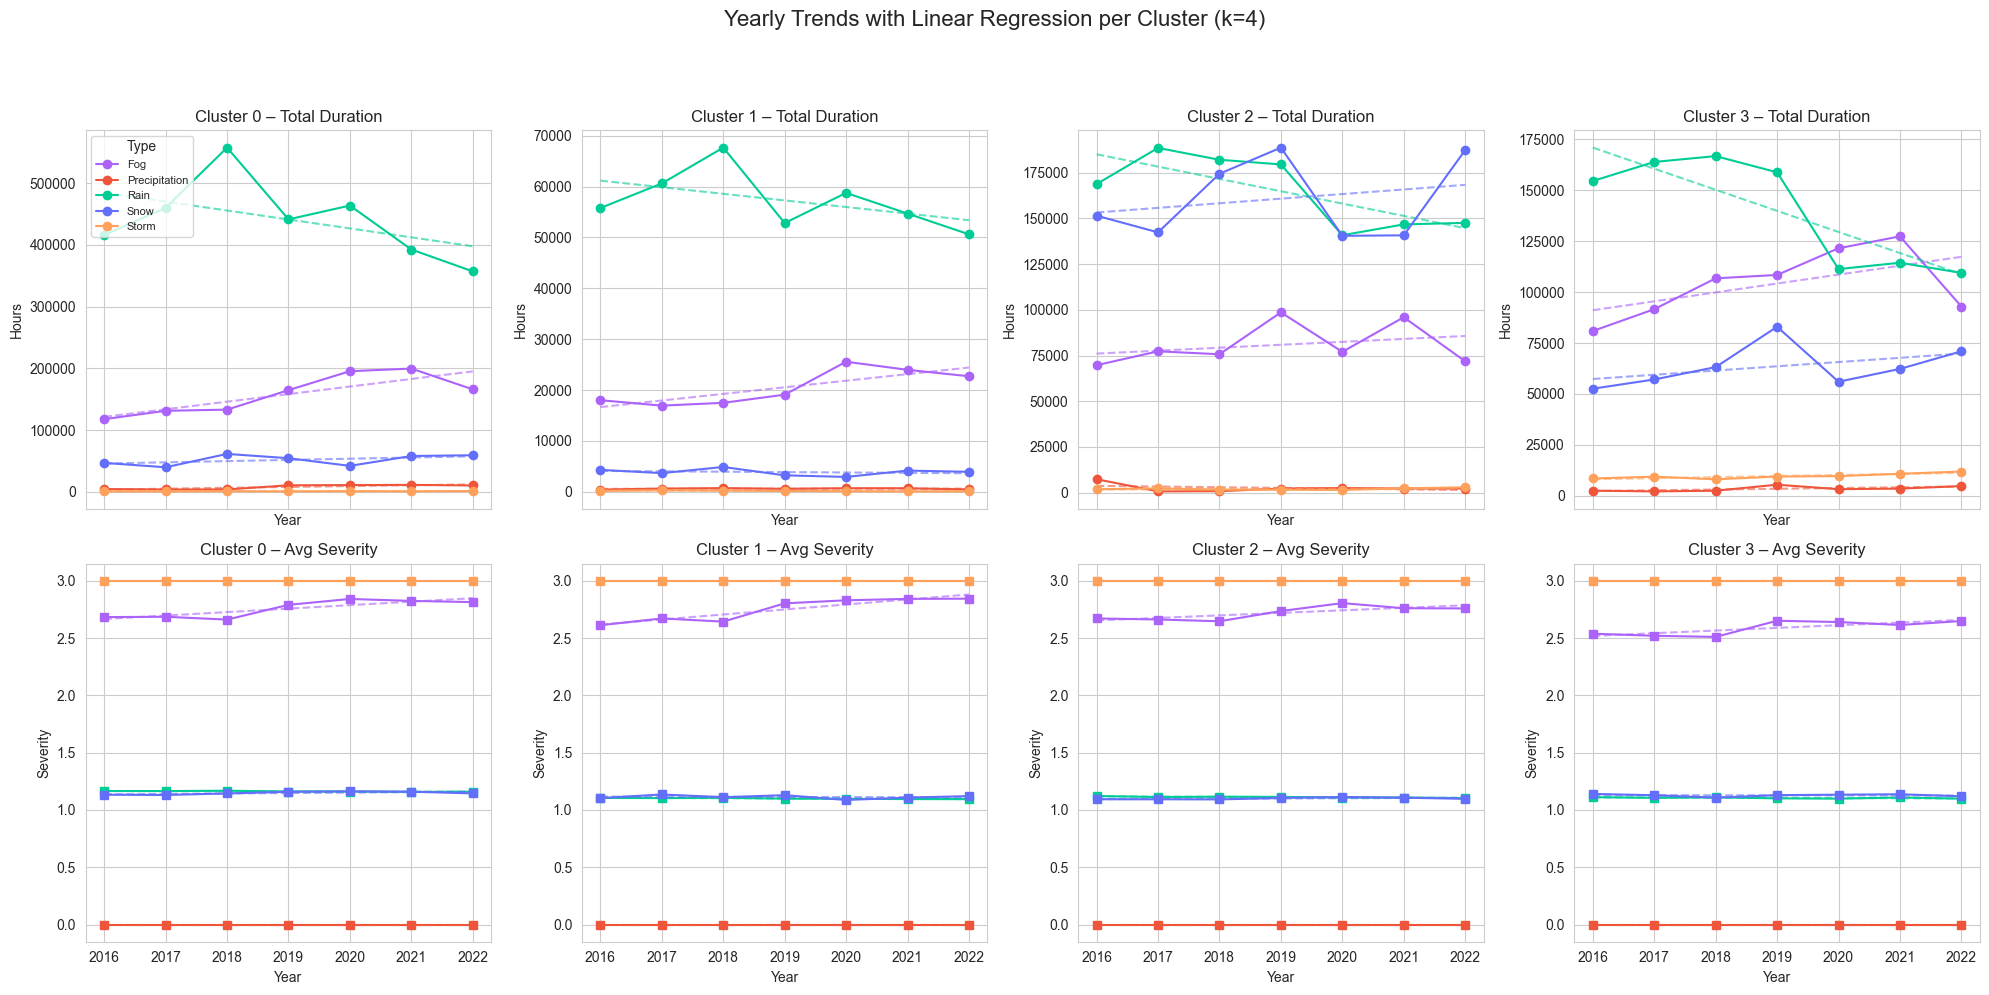

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ----------------------------------------------
# CONFIG — custom type colors from US map
# ----------------------------------------------
types = ["Fog", "Precipitation", "Rain", "Snow", "Storm"]
type_colors = {
    "Fog": "#AB63FA",
    "Precipitation": "#EF553B",
    "Rain": "#00CC96",
    "Snow": "#636EFA",
    "Storm": "#FFA15A"
}

# ----------------------------------------------
# ASSUMES: dfc with ['Cluster','year','Type','dur_h','sev_num']
# ----------------------------------------------
clusters = sorted(dfc["Cluster"].unique())
years = sorted(dfc["year"].unique())

fig, axes = plt.subplots(
    2, len(clusters),
    figsize=(5 * len(clusters), 10),
    sharex='col'
)

for j, c in enumerate(clusters):
    sub = dfc[dfc["Cluster"] == c]

    # -- total duration and severity matrices
    dur_mat = sub.groupby(["year", "Type"])["dur_h"].sum().unstack(fill_value=0)
    sev_mat = sub.groupby(["year", "Type"])["sev_num"].mean().unstack(fill_value=0)

    ax_dur, ax_sev = axes[0, j], axes[1, j]

    for t in types:
        col = type_colors[t]

        # --------------------  TOTAL DURATION  -------------------- #
        y_dur = dur_mat.reindex(years).get(t, pd.Series([0]*len(years))).values
        ax_dur.plot(years, y_dur, marker='o', color=col, label=t)

        # Linear regression for duration
        slope_dur, intercept_dur, *_ = linregress(years, y_dur)
        ax_dur.plot(
            years,
            intercept_dur + slope_dur * pd.Series(years),
            linestyle='--', color=col, alpha=0.6
        )

        # --------------------  AVG SEVERITY  ---------------------- #
        y_sev = sev_mat.reindex(years).get(t, pd.Series([0]*len(years))).fillna(0).values
        ax_sev.plot(years, y_sev, marker='s', linestyle='-', color=col)

        # Linear regression for severity
        slope_sev, intercept_sev, *_ = linregress(years, y_sev)
        ax_sev.plot(
            years,
            intercept_sev + slope_sev * pd.Series(years),
            linestyle='--', color=col, alpha=0.6
        )

    # Titles & labels
    ax_dur.set_title(f"Cluster {c} – Total Duration")
    ax_dur.set_ylabel("Hours")

    ax_sev.set_title(f"Cluster {c} – Avg Severity")
    ax_sev.set_ylabel("Severity")

    if j == 0:
        ax_dur.legend(title="Type", fontsize=8, loc="upper left")
        ax_sev.legend().remove()

    for ax in (ax_dur, ax_sev):
        ax.set_xticks(years)
        ax.set_xlabel("Year")

plt.suptitle("Yearly Trends with Linear Regression per Cluster (k=4)", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [22]:
from scipy.stats import linregress
import pandas as pd

rows = []
for c in sorted(dfc["Cluster"].unique()):
    sub = dfc[dfc["Cluster"] == c]
    dur_mat = sub.groupby(["year", "Type"])["dur_h"].sum().unstack(fill_value=0)
    sev_mat = sub.groupby(["year", "Type"])["sev_num"].mean().unstack(fill_value=0)

    for metric_name, mat in [("Duration", dur_mat), ("Severity", sev_mat)]:
        for t in mat.columns:
            y = mat[t].reindex(sorted(dfc["year"].unique())).fillna(0).values
            x = sorted(dfc["year"].unique())
            if np.count_nonzero(y) >= 3:
                slope, intercept, r_value, p_value, _ = linregress(x, y)
                rows.append({
                    "Cluster": c,
                    "Metric": metric_name,
                    "Type": t,
                    "Slope": slope,
                    "R²": r_value ** 2,
                    "P-value": p_value
                })

stats_df = pd.DataFrame(rows)


In [23]:
from IPython.display import display, Markdown

clusters = sorted(stats_df["Cluster"].unique())

for c in clusters:
    cluster_df = stats_df[stats_df["Cluster"] == c].copy()
    cluster_df = cluster_df[["Cluster", "Metric", "Type", "Slope", "R²", "P-value"]]
    
    display(Markdown(f"### 📊 Cluster {c} – Regression Statistics"))
    display(cluster_df.reset_index(drop=True).style.format({
        "Slope": "{:.4f}",
        "R²": "{:.3f}",
        "P-value": "{:.4f}"
    }))


### 📊 Cluster 0 – Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,0,Duration,Cold,-368.6589,0.017,0.7827
1,0,Duration,Fog,12276.5244,0.681,0.0222
2,0,Duration,Hail,-19.0667,0.159,0.3757
3,0,Duration,Precipitation,1407.0048,0.709,0.0174
4,0,Duration,Rain,-14472.3345,0.239,0.2650
5,0,Duration,Snow,1942.1143,0.231,0.2749
6,0,Duration,Storm,61.9673,0.410,0.1211
7,0,Severity,Cold,0.0000,0.000,1.0000
8,0,Severity,Fog,0.0303,0.723,0.0154
9,0,Severity,Rain,-0.0014,0.648,0.0290


### 📊 Cluster 1 – Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,1,Duration,Cold,215.3071,0.279,0.2234
1,1,Duration,Fog,1295.9327,0.647,0.0291
2,1,Duration,Hail,-5.4030,0.302,0.2013
3,1,Duration,Precipitation,7.1679,0.017,0.7778
4,1,Duration,Rain,-1296.2851,0.242,0.2620
5,1,Duration,Snow,-75.4863,0.060,0.5951
6,1,Duration,Storm,-28.4363,0.530,0.0637
7,1,Severity,Cold,0.0000,0.000,1.0000
8,1,Severity,Fog,0.0436,0.848,0.0033
9,1,Severity,Rain,-0.0020,0.821,0.0049


### 📊 Cluster 2 – Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,2,Duration,Cold,2215.3143,0.233,0.2721
1,2,Duration,Fog,1605.3369,0.090,0.5133
2,2,Duration,Hail,-19.3762,0.283,0.2188
3,2,Duration,Precipitation,-374.3476,0.132,0.4237
4,2,Duration,Rain,-6733.5042,0.553,0.0552
5,2,Duration,Snow,2516.3286,0.061,0.5936
6,2,Duration,Storm,109.5405,0.201,0.3137
7,2,Severity,Cold,0.0000,0.000,1.0000
8,2,Severity,Fog,0.0220,0.626,0.0340
9,2,Severity,Rain,-0.0025,0.835,0.0040


### 📊 Cluster 3 – Regression Statistics

,Cluster,Metric,Type,Slope,R²,P-value
0,3,Duration,Cold,-2708.3375,0.384,0.1377
1,3,Duration,Fog,4371.0077,0.316,0.1887
2,3,Duration,Hail,-4.7083,0.196,0.3203
3,3,Duration,Precipitation,364.6530,0.404,0.1247
4,3,Duration,Rain,-10356.2845,0.703,0.0184
5,3,Duration,Snow,2081.2887,0.186,0.3345
6,3,Duration,Storm,522.8119,0.741,0.0129
7,3,Severity,Cold,0.0000,0.000,1.0000
8,3,Severity,Fog,0.0232,0.622,0.0352
9,3,Severity,Rain,-0.0016,0.387,0.1359


In [24]:
from IPython.display import display, Markdown

# Filter significant results only
significant_df = stats_df[stats_df["P-value"] < 0.05].copy()
significant_df = significant_df.sort_values(["Cluster", "Metric", "R²"], ascending=[True, True, False])

for c in sorted(significant_df["Cluster"].unique()):
    cluster_df = significant_df[significant_df["Cluster"] == c]
    display(Markdown(f"### 🔍 Cluster {c} – Statistically Significant Trends (p < 0.05)"))
    display(cluster_df[["Metric", "Type", "Slope", "R²", "P-value"]].reset_index(drop=True).style.format({
        "Slope": "{:.4f}", "R²": "{:.3f}", "P-value": "{:.4f}"
    }))


### 🔍 Cluster 0 – Statistically Significant Trends (p < 0.05)

,Metric,Type,Slope,R²,P-value
0,Duration,Precipitation,1407.0048,0.709,0.0174
1,Duration,Fog,12276.5244,0.681,0.0222
2,Severity,Fog,0.0303,0.723,0.0154
3,Severity,Rain,-0.0014,0.648,0.0290


### 🔍 Cluster 1 – Statistically Significant Trends (p < 0.05)

,Metric,Type,Slope,R²,P-value
0,Duration,Fog,1295.9327,0.647,0.0291
1,Severity,Fog,0.0436,0.848,0.0033
2,Severity,Rain,-0.0020,0.821,0.0049


### 🔍 Cluster 2 – Statistically Significant Trends (p < 0.05)

,Metric,Type,Slope,R²,P-value
0,Severity,Rain,-0.0025,0.835,0.0040
1,Severity,Fog,0.0220,0.626,0.0340


### 🔍 Cluster 3 – Statistically Significant Trends (p < 0.05)

,Metric,Type,Slope,R²,P-value
0,Duration,Storm,522.8119,0.741,0.0129
1,Duration,Rain,-10356.2845,0.703,0.0184
2,Severity,Fog,0.0232,0.622,0.0352


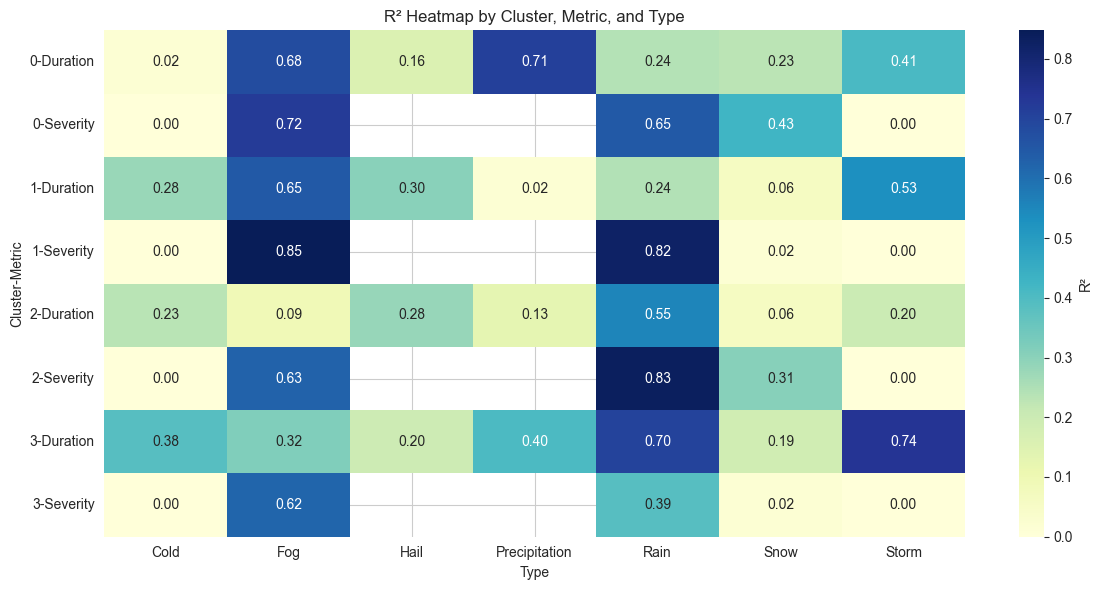

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot R² values for heatmap
r2_pivot = stats_df.pivot_table(
    index=["Cluster", "Metric"],
    columns="Type",
    values="R²"
)

plt.figure(figsize=(12, 6))
sns.heatmap(r2_pivot, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'R²'})
plt.title("R² Heatmap by Cluster, Metric, and Type")
plt.tight_layout()
plt.show()
